In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# parameters of figure
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# Basic LSTM Model


### Oil Price Data Processing

In [2]:
# read oil price data
oil_price = pd.read_csv('DCOILWTICO.csv')
oil_price.head()

,DATE,DCOILWTICO
0,2012-01-03,102.96
1,2012-01-04,103.22
2,2012-01-05,101.81
3,2012-01-06,101.56
4,2012-01-09,101.31


In [3]:
oil_price.shape

(2086, 2)

In [4]:
# Convert string to Datetime
oil_price['DATE'] = pd.to_datetime(oil_price['DATE'])

In [5]:
# Process the oil price data, there are some '.' data in it
oil_price.loc[oil_price['DCOILWTICO'] == '.','DCOILWTICO'] = np.nan

# Fill the None with the last day's price
oil_price = oil_price.fillna(method='pad')

In [6]:
# Set time as index
oil_price = oil_price.set_index('DATE')
oil_price

,DCOILWTICO
DATE,
2012-01-03,102.96
2012-01-04,103.22
2012-01-05,101.81
2012-01-06,101.56
2012-01-09,101.31
...,...
2019-12-25,61.17
2019-12-26,61.72
2019-12-27,61.76


### Plot the oil price trend

<AxesSubplot:xlabel='DATE'>

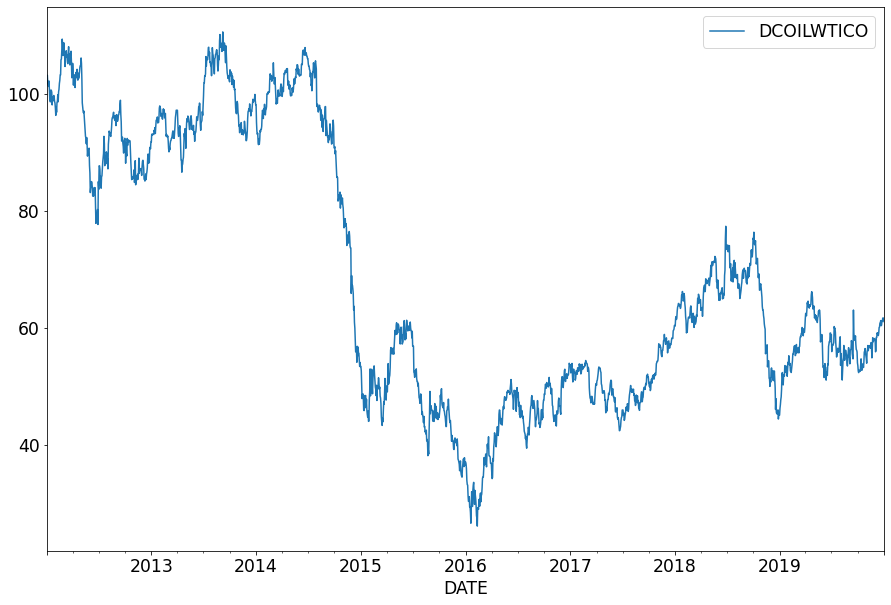

In [7]:
# Convert the price data type to 'float'
oil_price['DCOILWTICO'] = oil_price['DCOILWTICO'].astype(float)

# plot the price trend
oil_price.plot()

### Divide the dataset into train set and test set

In [8]:
# Select 75% of the total data as the training set
train_size = int(len(oil_price) * 0.75)
test_size = len(oil_price) - train_size
train = oil_price.iloc[0:train_size]
test = oil_price.iloc[train_size: len(oil_price)]
display(len(train), len(test))

1564

522

### Normalisation of data

In the following cell, you can choose one of the normalization methods, MinMaxScaler or RobustScaler

In [9]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler


# dcoilwtico_transformer = MinMaxScaler()
dcoilwtico_transformer = RobustScaler()
train['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(train[['DCOILWTICO']])
test['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(test[['DCOILWTICO']])

C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_12816\1347920800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(train[['DCOILWTICO']])
C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_12816\1347920800.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(test[['DCOILWTICO']])


### Construct the X_train, y_train, X_test, y_test with time_step=30

In [10]:
# Construct the input data based on formula Y^((t))=f({x^((t-n)),…,x^((t-2)), x^((t-1) )})
def create_dataset_LSTM(X, y, time_steps):
    Xs = []
    ys = []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
time_steps = 30
X_train, y_train = create_dataset_LSTM(train, train.DCOILWTICO, time_steps)
X_test, y_test = create_dataset_LSTM(test, test.DCOILWTICO, time_steps)
print(X_train.shape, y_train.shape)

(1534, 30, 1) (1534,)


### Build LSTM models

There are 6 models are constructed this part aims to find the architecture with best performance

In [12]:
from tensorflow import keras

# model with 1 uni-directional lstm layer
model_1_1 = keras.Sequential()
model_1_1.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1_1.add(keras.layers.Dropout(rate=0.2))
model_1_1.add(keras.layers.Dense(units=1))
model_1_1.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# model with 2 uni-directional lstm layers
model_1_2 = keras.Sequential()
model_1_2.add(keras.layers.LSTM(units=64, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1_2.add(keras.layers.LSTM(units=64))
model_1_2.add(keras.layers.Dropout(rate=0.2))
model_1_2.add(keras.layers.Dense(units=1))
model_1_2.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
# model with 3 uni-directional lstm layers
model_1_3 = keras.Sequential()
model_1_3.add(keras.layers.LSTM(units=64, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1_3.add(keras.layers.LSTM(units=64, return_sequences = True))
model_1_3.add(keras.layers.LSTM(units=64))
model_1_3.add(keras.layers.Dropout(rate=0.2))
model_1_3.add(keras.layers.Dense(units=1))
model_1_3.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
# model with 1 bidirectional lstm layer
model_2_1 = keras.Sequential()
model_2_1.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
             )
model_2_1.add(keras.layers.Dropout(rate=0.2))
model_2_1.add(keras.layers.Dense(units=1))
model_2_1.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
# model with 2 bidirectional lstm layers
model_2_2 = keras.Sequential()
model_2_2.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=64, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
             )
model_2_2.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64)))
model_2_2.add(keras.layers.Dropout(rate=0.2))
model_2_2.add(keras.layers.Dense(units=1))
model_2_2.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
# model with 3 bidirectional lstm layers
model_2_3 = keras.Sequential()
model_2_3.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=64, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
             )
model_2_3.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences = True)))
model_2_3.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64)))
model_2_3.add(keras.layers.Dropout(rate=0.2))
model_2_3.add(keras.layers.Dense(units=1))
model_2_3.compile(loss='mean_squared_error',optimizer='adam')

### Define functions for model training, data visualization and Mean Square Error (MSE) calculation

In [18]:
# Function for training
def training(model, X_train, y_train, epochs_num):  
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs_num, 
        batch_size=64, 
        validation_split=0.1, 
        shuffle=False
    )
    return history, model


# Define the function to plot the loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='validation_loss')
    plt.legend()


# Function for plotting the prediction results
def predict_results_plot(scaler, y_pred, y_test_inv):
    y_pred_inv = scaler.inverse_transform(y_pred)
    plt.plot(y_test_inv.flatten(), marker='.', label="true")
    plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
    plt.ylabel('Crude Oil Price')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

    
# Function for calculating the Mean Square Error (MSE)
def MSE(y_test_inv, y_pred):
    y_pred_inv = dcoilwtico_transformer.inverse_transform(y_pred)
    MSE = np.sum((y_test_inv.flatten()-y_pred_inv.flatten()) ** 2)/y_test_inv.shape[1]
    return MSE


### Model training

In [19]:
history1, model_1_1 = training(model_1_1, X_train, y_train, 120)
history2, model_1_2 = training(model_1_2, X_train, y_train, 120)
history3, model_1_3 = training(model_1_3, X_train, y_train, 120)
history4, model_2_1 = training(model_2_1, X_train, y_train, 120)
history5, model_2_2 = training(model_2_2, X_train, y_train, 120)
history6, model_2_3 = training(model_2_3, X_train, y_train, 120)

Epoch 1/120
22/22 [==============================] - 2s 22ms/step - loss: 0.2211 - val_loss: 0.0152
Epoch 2/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0766 - val_loss: 0.0066
Epoch 3/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0426 - val_loss: 0.0015
Epoch 4/120
22/22 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0011
Epoch 5/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 6/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 7/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 8/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 9/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0010
Epoch 10/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 1

22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 5.5629e-04
Epoch 81/120
22/22 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 5.4533e-04
Epoch 82/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 5.9065e-04
Epoch 83/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 5.5392e-04
Epoch 84/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 5.9710e-04
Epoch 85/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 5.7033e-04
Epoch 86/120
22/22 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 5.6846e-04
Epoch 87/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 5.5495e-04
Epoch 88/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 5.3222e-04
Epoch 89/120
22/22 [==============================] - 0s 9ms/step - loss: 0.0

22/22 [==============================] - 0s 19ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 40/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 8.0771e-04
Epoch 41/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 42/120
22/22 [==============================] - 0s 20ms/step - loss: 0.0068 - val_loss: 9.2041e-04
Epoch 43/120
22/22 [==============================] - 0s 20ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 44/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 7.8203e-04
Epoch 45/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0045 - val_loss: 9.9452e-04
Epoch 46/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0070 - val_loss: 7.7508e-04
Epoch 47/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0039 - val_loss: 9.5895e-04
Epoch 48/120
22/22 [==============================] - 0s 19ms/step - loss: 0.005

22/22 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 5.6629e-04
Epoch 118/120
22/22 [==============================] - 0s 20ms/step - loss: 0.0035 - val_loss: 5.6456e-04
Epoch 119/120
22/22 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 7.0802e-04
Epoch 120/120
22/22 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 5.5210e-04
Epoch 1/120
22/22 [==============================] - 4s 62ms/step - loss: 0.1300 - val_loss: 0.0152
Epoch 2/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0640 - val_loss: 0.0126
Epoch 3/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0198 - val_loss: 0.0032
Epoch 4/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0160 - val_loss: 0.0020
Epoch 5/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0142 - val_loss: 0.0019
Epoch 6/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0083 - val_los

Epoch 77/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 78/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 8.1995e-04
Epoch 79/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0046 - val_loss: 6.2890e-04
Epoch 80/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0043 - val_loss: 7.4722e-04
Epoch 81/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 7.4174e-04
Epoch 82/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0037 - val_loss: 6.2562e-04
Epoch 83/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 5.7647e-04
Epoch 84/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 6.0544e-04
Epoch 85/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0031 - val_loss: 6.9412e-04
Epoch 86/120
22/22 [==============================] - 1s 31

22/22 [==============================] - 0s 12ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 37/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 8.2126e-04
Epoch 38/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 39/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 8.3966e-04
Epoch 40/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 41/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 8.5713e-04
Epoch 42/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 9.6659e-04
Epoch 43/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 7.9885e-04
Epoch 44/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 45/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0038 - 

22/22 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 6.4292e-04
Epoch 115/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 5.4388e-04
Epoch 116/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 6.8772e-04
Epoch 117/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 5.7624e-04
Epoch 118/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 6.9241e-04
Epoch 119/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 6.0131e-04
Epoch 120/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 8.1874e-04
Epoch 1/120
22/22 [==============================] - 6s 84ms/step - loss: 0.1004 - val_loss: 0.0060
Epoch 2/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0395 - val_loss: 0.0018
Epoch 3/120
22/22 [==============================] - 1s 30ms/step - loss

Epoch 73/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0033 - val_loss: 3.9592e-04
Epoch 74/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0028 - val_loss: 4.7648e-04
Epoch 75/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0027 - val_loss: 5.3207e-04
Epoch 76/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0025 - val_loss: 7.3371e-04
Epoch 77/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0026 - val_loss: 4.7301e-04
Epoch 78/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0024 - val_loss: 5.9678e-04
Epoch 79/120
22/22 [==============================] - 1s 30ms/step - loss: 0.0024 - val_loss: 4.5549e-04
Epoch 80/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0025 - val_loss: 3.9890e-04
Epoch 81/120
22/22 [==============================] - 1s 31ms/step - loss: 0.0027 - val_loss: 4.3144e-04
Epoch 82/120
22/22 [==============================] - 1

22/22 [==============================] - 1s 44ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 33/120
22/22 [==============================] - 1s 43ms/step - loss: 0.0100 - val_loss: 0.0015
Epoch 34/120
22/22 [==============================] - 1s 44ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 35/120
22/22 [==============================] - 1s 44ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 36/120
22/22 [==============================] - 1s 43ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 37/120
22/22 [==============================] - 1s 47ms/step - loss: 0.0105 - val_loss: 0.0015
Epoch 38/120
22/22 [==============================] - 1s 46ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 39/120
22/22 [==============================] - 1s 46ms/step - loss: 0.0116 - val_loss: 0.0012
Epoch 40/120
22/22 [==============================] - 1s 43ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 41/120
22/22 [==============================] - 1s 44ms/step - loss: 0.0090 - val_loss: 0.0016
Epo

22/22 [==============================] - 1s 46ms/step - loss: 0.0033 - val_loss: 9.4076e-04
Epoch 113/120
22/22 [==============================] - 1s 46ms/step - loss: 0.0062 - val_loss: 9.7911e-04
Epoch 114/120
22/22 [==============================] - 1s 46ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 115/120
22/22 [==============================] - 1s 46ms/step - loss: 0.0067 - val_loss: 9.5990e-04
Epoch 116/120
22/22 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 117/120
22/22 [==============================] - 1s 45ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 118/120
22/22 [==============================] - 1s 51ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 119/120
22/22 [==============================] - 1s 44ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 120/120
22/22 [==============================] - 1s 44ms/step - loss: 0.0037 - val_loss: 0.0013


### Plot the loss on both training set and validation set

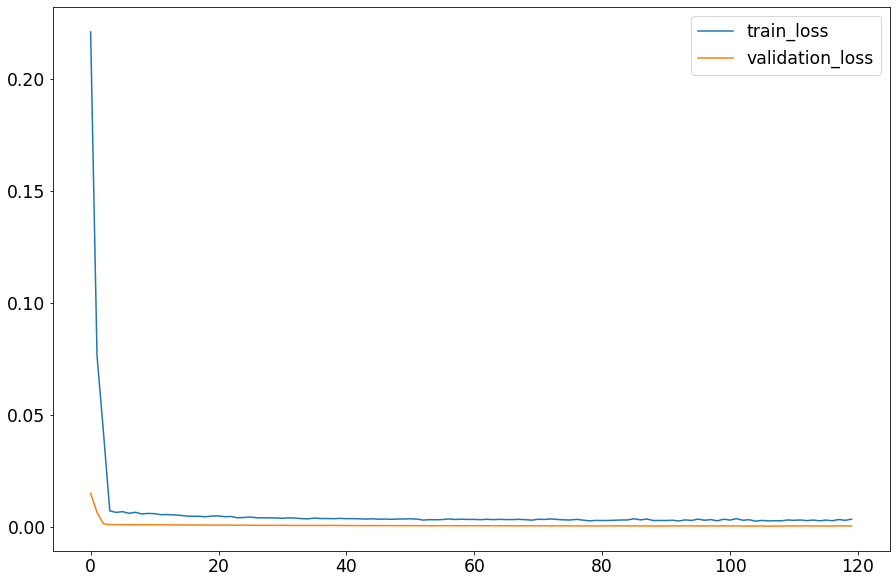

In [20]:
plot_loss(history1)
# plot_loss(history2)
# plot_loss(history3)
# plot_loss(history4)
# plot_loss(history5)
# plot_loss(history6)

### Model Prediction

In [21]:
# Inverse normalisation of data
y_test_inv = dcoilwtico_transformer.inverse_transform(y_test.reshape(1, -1))

# # model 1
y_pred11 = model_1_1.predict(X_test)
MSE11 = MSE(y_test_inv, y_pred11)

# # model 2
y_pred12 = model_1_2.predict(X_test)
MSE12 = MSE(y_test_inv, y_pred12)


# # model 3
y_pred13 = model_1_3.predict(X_test)
MSE13 = MSE(y_test_inv, y_pred13)

# # model 4
y_pred21 = model_2_1.predict(X_test)
MSE21 = MSE(y_test_inv, y_pred21)

# model 5
y_pred22 = model_2_2.predict(X_test)
MSE22 = MSE(y_test_inv, y_pred22)

# # model 6
y_pred23 = model_2_3.predict(X_test)
MSE23 = MSE(y_test_inv, y_pred23)


display(MSE11, MSE12, MSE13, MSE21, MSE22, MSE23)

16/16 [==============================] - 1s 8ms/step


2.5475408543696147

2.1537780310221795

3.2647436101850436

3.056916947481261

2.0751122388815415

4.182996772448882

### Results Visualization

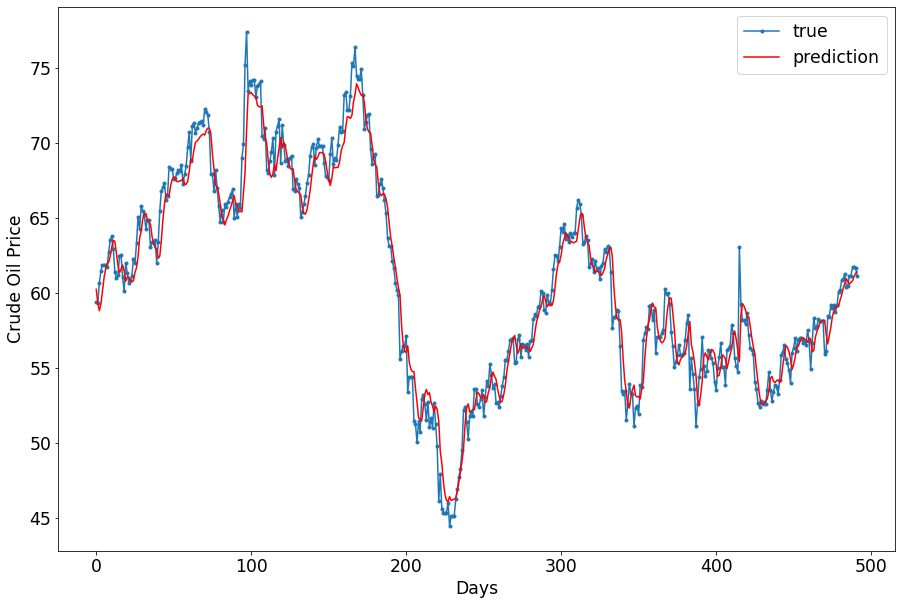

In [22]:
predict_results_plot(dcoilwtico_transformer, y_pred22, y_test_inv)

# LSTM Model with Sentiment Score

### Read News Headlines

In [23]:
# read news headlines data
news_head_df = pd.read_excel('Oil_News_Headlines.xlsx')
news_head_df

,text,date
0,"Oil Dips as 2019 Ends; Big Gains on Year, Big ...","Dec 31, 2019"
1,Oil falls but on track for biggest yearly rise...,"Dec 31, 2019"
2,Russian firms divert oil from Belarus as no 20...,"Dec 31, 2019"
3,Global stocks end 2019 close to record highs,"Dec 31, 2019"
4,Oil prices set for biggest yearly rise since 2...,"Dec 30, 2019"
...,...,...
22644,"Crude oil trades above USD100 on Iran fears, C...","Jan 03, 2012"
22645,Asia stocks rally in post-holiday trade; Hang ...,"Jan 03, 2012"
22646,Natural gas futures - Weekly outlook: January ...,"Jan 01, 2012"
22647,Crude oil futures - Weekly outlook: January 2 - 6,"Jan 01, 2012"


### Process the empty value

In [24]:
# delete the empty data
null_index = news_head_df.index[(news_head_df['date'] == ' ')]
news_head_df.drop(null_index, inplace=True)

### Change the format of the date

In [25]:
# Example: Jan 01, 2012 ----> 2012-01-01
news_head_df['date'] = pd.to_datetime(news_head_df['date'], format = '%b %d, %Y')
news_head_df.head()

,text,date
0,"Oil Dips as 2019 Ends; Big Gains on Year, Big ...",2019-12-31
1,Oil falls but on track for biggest yearly rise...,2019-12-31
2,Russian firms divert oil from Belarus as no 20...,2019-12-31
3,Global stocks end 2019 close to record highs,2019-12-31
4,Oil prices set for biggest yearly rise since 2...,2019-12-30


### Calculate Sentiment Polarity

In [26]:
from textblob import TextBlob

# Calculate the sentiment score of a single headline
def get_sentiment(headline):
    blob = TextBlob(headline)
    return blob.sentiment.polarity

# Calculate the average sentiment score of the dataframe of a date
def get_average_sentiment(data_frame):
    score_list = []
    for index, values in data_frame.iterrows():
        polarity_score = get_sentiment(values['text'])
        score_list.append(polarity_score)
    return np.mean(score_list)  

In [27]:
# Obtain the Series of date
date_series = news_head_df['date'].drop_duplicates()
date_series = date_series.reset_index(drop=True)
date_series

0      2019-12-31
1      2019-12-30
2      2019-12-29
3      2019-12-27
4      2019-12-26
          ...    
2550   2012-01-06
2551   2012-01-05
2552   2012-01-04
2553   2012-01-03
2554   2012-01-01
Name: date, Length: 2555, dtype: datetime64[ns]

In [28]:
polarity_score_list = []
# Iterate the date Series
for value in date_series.values:
    df_corresponding_date = news_head_df[news_head_df['date'] == value]
    polarity_score = get_average_sentiment(df_corresponding_date)
    polarity_score_list.append(polarity_score)

score_series = pd.Series(polarity_score_list)
score_series

0       0.000000
1       0.019815
2       0.000000
3      -0.016667
4      -0.040000
          ...   
2550   -0.416667
2551   -0.091296
2552   -0.183125
2553   -0.341667
2554   -0.200000
Length: 2555, dtype: float64

### Construct the data frame with date and sentiment score

In [29]:
date_sentiment_df = pd.DataFrame({'DATE':date_series, 'SENTIMENT SCORE':score_series})
date_sentiment_df

,DATE,SENTIMENT SCORE
0,2019-12-31,0.000000
1,2019-12-30,0.019815
2,2019-12-29,0.000000
3,2019-12-27,-0.016667
4,2019-12-26,-0.040000
...,...,...
2550,2012-01-06,-0.416667
2551,2012-01-05,-0.091296
2552,2012-01-04,-0.183125
2553,2012-01-03,-0.341667


### Merge two date frames

In [30]:
oil_price_sentiment_df = pd.merge(oil_price, date_sentiment_df, on='DATE')
oil_price_sentiment_df = oil_price_sentiment_df.set_index('DATE')
oil_price_sentiment_df

,DCOILWTICO,SENTIMENT SCORE
DATE,,
2012-01-03,102.96,-0.341667
2012-01-04,103.22,-0.183125
2012-01-05,101.81,-0.091296
2012-01-06,101.56,-0.416667
2012-01-09,101.31,-0.420000
...,...,...
2019-12-24,61.17,-0.035417
2019-12-26,61.72,-0.040000
2019-12-27,61.76,-0.016667


### Build train set and test set

In [31]:
senti_train_size = int(len(oil_price_sentiment_df) * 0.75)
senti_test_size = len(oil_price_sentiment_df) - senti_train_size
senti_train, senti_test = oil_price_sentiment_df.iloc[0:senti_train_size], oil_price_sentiment_df.iloc[senti_train_size:len(oil_price_sentiment_df)]
print(len(senti_train), len(senti_test))

1551 518


### Data Normalization

In [32]:
# dcoi_transformer = MinMaxScaler()
dcoi_transformer = RobustScaler()
senti_train['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_train[['DCOILWTICO']])
senti_test['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_test[['DCOILWTICO']])

C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_12816\1873222913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_train['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_train[['DCOILWTICO']])
C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_12816\1873222913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_test['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_test[['DCOILWTICO']])


### Set the time_step

In [33]:
senti_time_steps = 30

X_train_senti, y_train_senti = create_dataset_LSTM(senti_train, senti_train.DCOILWTICO, senti_time_steps)
X_test_senti, y_test_senti = create_dataset_LSTM(senti_test, senti_test.DCOILWTICO, senti_time_steps)
print(X_train_senti.shape, y_train_senti.shape)


(1521, 30, 2) (1521,)


### Construct the Network

In [34]:
# network with two bidirectional LSTM layers
model_senti = keras.Sequential()
model_senti.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=64, return_sequences = True, input_shape=(X_train_senti.shape[1], X_train_senti.shape[2])))
               )
model_senti.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64)))
model_senti.add(keras.layers.Dropout(rate=0.2))
model_senti.add(keras.layers.Dense(units=1))
model_senti.compile(loss='mean_squared_error', optimizer='adam')

### Model Training


In [35]:
history_senti, model_senti = training(model_senti,X_train_senti, y_train_senti, 120)

Epoch 1/120
22/22 [==============================] - 6s 68ms/step - loss: 0.0707 - val_loss: 0.0032
Epoch 2/120
22/22 [==============================] - 1s 26ms/step - loss: 0.0393 - val_loss: 0.0035
Epoch 3/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0169 - val_loss: 0.0013
Epoch 4/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 5/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 6/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 7/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 8/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 9/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 10/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0098 - val_loss: 0.0012

22/22 [==============================] - 1s 27ms/step - loss: 0.0025 - val_loss: 6.7705e-04
Epoch 80/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0023 - val_loss: 4.2237e-04
Epoch 81/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0023 - val_loss: 4.4035e-04
Epoch 82/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0025 - val_loss: 7.6100e-04
Epoch 83/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0027 - val_loss: 9.8439e-04
Epoch 84/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 5.4020e-04
Epoch 85/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0024 - val_loss: 4.1743e-04
Epoch 86/120
22/22 [==============================] - 1s 28ms/step - loss: 0.0028 - val_loss: 4.8067e-04
Epoch 87/120
22/22 [==============================] - 1s 27ms/step - loss: 0.0038 - val_loss: 4.9314e-04
Epoch 88/120
22/22 [==============================] - 1s 28ms/step -

### Model Prediction

In [37]:
# Function for calculating the Mean Square Error (MSE)
def MSE_senti(y_test_inv, y_pred):
    y_pred_inv = dcoi_transformer.inverse_transform(y_pred)
    MSE = np.sum((y_test_inv.flatten()-y_pred_inv.flatten()) ** 2)/y_test_inv.shape[1]
    return MSE

In [38]:
y_pred_senti = model_senti.predict(X_test_senti)

# Inverse normalisation of data
y_test_inv_senti = dcoi_transformer.inverse_transform(y_test_senti.reshape(1, -1))
MSE_senti = MSE_senti(y_test_inv_senti, y_pred_senti)
MSE_senti

16/16 [==============================] - 1s 5ms/step


1.923383534796067

### Result Visualization

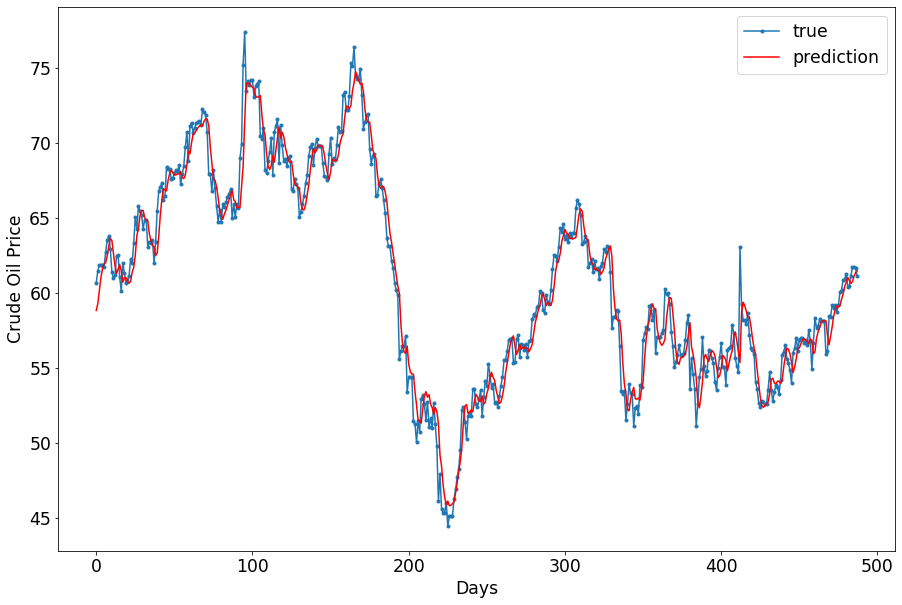

In [39]:
predict_results_plot(dcoi_transformer,y_pred_senti, y_test_inv_senti)